# Fits and characterizes final model for 4-week outcome

Gaylen Fronk  
May 22, 2024

### Set Up Environment

In [ ]:
study <- params$study
version <- params$version
cv <- params$cv
y_col_name <- params$y_col_name


Packages for script

In [ ]:

library(tidymodels)


── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.5      ✔ recipes      1.0.10
✔ dials        1.2.1      ✔ rsample      1.2.1 
✔ dplyr        1.1.4      ✔ tibble       3.2.1 
✔ ggplot2      3.5.1      ✔ tidyr        1.3.1 
✔ infer        1.0.7      ✔ tune         1.2.1 
✔ modeldata    1.3.0      ✔ workflows    1.1.4 
✔ parsnip      1.2.1      ✔ workflowsets 1.1.0 
✔ purrr        1.0.2      ✔ yardstick    1.3.1 

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Use tidymodels_prefer() to resolve common conflicts.

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ lubridate 1.9.3     ✔ stringr   1.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks stats::filter()
✖ stringr::fixed()    masks recipes::fixed()
✖ dplyr::lag()        masks stats::lag()
✖ readr::spec()       masks yardstick::spec()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'Matrix'

The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Attaching package: 'probably'

The following objects are masked from 'package:base':

    as.factor, as.ordered

here() starts at C:/Users/gfronk/Documents/GitHub/study_match

ℹ SHA-1 hash of file is "c045eee2655a18dc85e715b78182f176327358a7"

ℹ SHA-1 hash of file is "b58b9e0adc05e89609ee8bc6f20c39375b262fe6"

Handle conflicts

In [ ]:

options(conflicts.policy = "depends.ok")


Absolute paths

In [ ]:
switch (Sys.info()[['sysname']],
        # PC paths
        Windows = {
          path_input <- stringr::str_c("P:/studydata/match/chtc/", 
                                       y_col_name)
          path_models <- stringr::str_c("P:/studydata/match/models/", 
                                        y_col_name)},
        
        # IOS paths
        Darwin = {
          path_input <- stringr::str_c("/Volumes/private/studydata/match/chtc/", 
                                       y_col_name)
          path_models <- stringr::str_c("/Volumes/private/studydata/match/models/", 
                                        y_col_name)},
        
        # Linux paths
        Linux = {
          path_input <- stringr::str_c("~/mnt/private/studydata/match/chtc/", 
                                       y_col_name)
          path_models <- stringr::str_c("~/mnt/private/studydata/match/models/", 
                                        y_col_name)}
)


Chunk Defaults

In [ ]:

knitr::opts_chunk$set(attr.output='style="max-height: 500px;"')

options(tibble.width = Inf)
options(tibble.print_max = Inf)


### Read in best configuration

Selected in 1_metrics_inner (k-fold CV)

In [ ]:
best_config <- read_csv(file.path(path_models, 
                                  str_c("best_config_", version, ".csv")),
                        show_col_types = FALSE)

glimpse(best_config)


Rows: 1
Columns: 14
$ n_jobs       <dbl> 10
$ algorithm    <chr> "glmnet"
$ feature_set  <chr> "item_ordinal"
$ hp1          <dbl> 0.1
$ hp2          <dbl> 0.1326421
$ hp3          <lgl> NA
$ resample     <chr> "up_1"
$ accuracy     <dbl> 0.6651376
$ bal_accuracy <dbl> 0.6535065
$ roc_auc      <dbl> 0.7358708
$ sens         <dbl> 0.6524493
$ spec         <dbl> 0.6377969
$ ppv          <dbl> 0.4682609
$ npv          <dbl> 0.7860704

### Fit best model in full dataset

**NOTE**: This model will only be used for 1) examining parameter estimates, and 2) ultimate dissemination.

In [ ]:
batch_names <- list.dirs(path_input, full.names = FALSE, recursive = FALSE) 

batch_name <- batch_names[str_detect(batch_names, "train") & 
                            str_detect(batch_names, cv) &
                            str_detect(batch_names, version) &
                            str_detect(batch_names, best_config$algorithm)] 

path_batch <- file.path(path_input, batch_name)
source(file.path(path_batch, "input", "training_controls.R"))

d <- read_csv(file.path(path_batch, "input", "data_trn.csv"), 
              show_col_types = FALSE) 

d_outcomes <- d |> 
  select(subid, ends_with("outcome") & contains("hybrid"))

d <- format_data(d) 

rec <- build_recipe(d = d, config = best_config)

rec_prepped_full <- rec |> 
  prep(training = d, strings_as_factors = FALSE)

feat_all <- rec_prepped_full |> 
  bake(new_data = d)

model_best <- fit_best_model(best_model = best_config, 
                             feat = feat_all, 
                             ml_mode = "classification")


### Model coefficients

**NOTE**: Coefficients are naturally inverted (i.e., positive class \[abstinence\] treated as first \[vs. second\] class). Here, we multiply coefficients by -1 to align the direction of coefficients with the rest of our analyses. Once flipped (i.e., as they appear below)…

A *positive coefficient* indicates that increases in the feature *increase* the likelihood of abstinence. For example, increases in motivation to quit (“motive_quit_order”) *increase* the likelihood of abstinence.

A *negative coefficient* indicates that increases in the feature *decrease* the likelihood of smoking. For example, increases in carbon monoxide (“co”) *decrease* the likelihood of abstinence.

In [ ]:
model_tidy <- tidy(model_best)


Loaded glmnet 4.1-8

In [ ]:
retained_vars <- model_tidy |> 
  mutate(estimate = estimate * -1) |> 
  filter(abs(estimate) > 0) |> 
  select(-penalty) |> 
  arrange(desc(abs(estimate)))

print_kbl(retained_vars, digits = 4)


10.91% of features were retained by the glmnet solution (128 features of a total considered 1173 features).

In [ ]:
retained_vars_tx <- retained_vars |> 
  filter(str_detect(term, "treatment_")) |> 
  arrange(desc(abs(estimate))) 

print_kbl(retained_vars_tx, digits = 4)


43.75% of the retained features were treatment interaction features (56 treatment features of 128 retained features). Of the 879 available treatment interaction features, 6% were retained.

### Calculate and calibrate probabilities

Make triplicate dataset

In [ ]:
d_patch <- d |> 
  mutate(treatment = "patch") 

d_combo <- d |> 
  mutate(treatment = "combo_nrt")

d_varen <- d |> 
  mutate(treatment = "varenicline")

d_trip <- bind_rows(d_patch, d_combo) |> 
  bind_rows(d_varen) |> 
  mutate(treatment = factor(treatment, 
                            levels = c(
                              "patch",
                              "varenicline",
                              "combo_nrt")))


Make function to: 1) hold out each sub once, 2) fit model with remaining 1085 subs, 3) get 3 raw predictions for held-out sub, 4) get calibrated predictions for held-out sub

In [ ]:
get_triple_probs <- function(i_sub, best_config, d, d_trip){
  
  # hold out single subject
  d_out <- d_trip |> 
    filter(subid == i_sub)
  
  d_in <- d |> 
    filter(subid != i_sub)
  
  # prep recipe 
  rec <- build_recipe(d = d_in, config = best_config)
  rec_prepped <- rec |> 
    prep(training = d_in, strings_as_factors = FALSE)
  
  # bake feat_in and feat_out
  feat_in <- rec_prepped |> 
    bake(new_data = NULL)
  
  feat_out <- rec_prepped |> 
    bake(new_data = d_out)
  
  # fit model
  model_best <- fit_best_model(best_config, feat = feat_in,
                               "classification")
  
  # raw (uncalibrated) predictions
  preds_prob <- predict(model_best, feat_out,
                        type = "prob")
  
  # fit calibration model
  set.seed(2468)
  cal_split <- d_in |> 
    initial_split(prop = 3/4, strata = y)
  d_cal_in <- training(cal_split) 
  d_cal_out <- testing(cal_split)
  
  rec_cal_prepped <- rec |> 
    prep(training = d_cal_in, strings_as_factors = FALSE)
  
  feat_cal_in <- rec_cal_prepped |> 
    bake(new_data = NULL) 
  
  feat_cal_out <- rec_cal_prepped |> 
    bake(new_data = d_cal_out) 
  
  model_cal <- fit_best_model(best_config, feat = feat_cal_in, "classification")
  
  # beta calibration
  beta <- predict(model_cal, feat_cal_out,
                  type = "prob") |>
    mutate(truth = feat_cal_out$y) |>
    cal_estimate_beta(truth = truth,
                      estimate = dplyr::starts_with(".pred_"),
                      smooth = TRUE)
  preds_prob_beta <- preds_prob |>
    cal_apply(beta)
  
  # iso calibration
  iso <- predict(model_cal, feat_cal_out,
                 type = "prob") |>
    mutate(truth = feat_cal_out$y) |>
    cal_estimate_isotonic(truth = truth,
                          estimate = dplyr::starts_with(".pred_"))
  preds_prob_iso <- preds_prob |>
    cal_apply(iso)
  
  # logistic calibration
  logi <- predict(model_cal, feat_cal_out,
                  type = "prob") |>
    mutate(truth = feat_cal_out$y) |>
    cal_estimate_logistic(truth = truth,
                          estimate = dplyr::starts_with(".pred_"),
                          smooth = TRUE)
  preds_prob_logi <- preds_prob |>
    cal_apply(logi)
  
  # combine raw and calibrated probs
  probs <- tibble(subid = d_out$subid,
                  tx = d_out$treatment,
                  prob_raw = preds_prob[[str_c(".pred_", y_level_pos)]],
                  prob_beta = preds_prob_beta[[str_c(".pred_", y_level_pos)]],
                  prob_iso = preds_prob_iso[[str_c(".pred_", y_level_pos)]],
                  prob_logi = preds_prob_logi[[str_c(".pred_", y_level_pos)]]) 
}


Map over participants so that each is held-out once

In [ ]:
if(file.exists(file.path(path_models, 
                         str_c("trip_probs_", version, ".csv")))) {
  all_probs <- read_csv(file.path(path_models, 
                                  str_c("trip_probs_", version, ".csv")),
                        show_col_types = FALSE)
} else {
  all_probs <- d$subid |> 
  map(\(i_sub) get_triple_probs(i_sub, best_config, d, d_trip)) |> 
  list_rbind()
  
  all_probs |> 
    write_csv(file.path(path_models, 
                        str_c("trip_probs_", version, ".csv")))
}


## FIGURE OUT WHAT IS GOING ON

Make predictions for subid 20010

In [ ]:
# make d_out
d_20010 <- d_trip |> 
  filter(subid == 20010)

# from model fit on full dataset
feat_out_full <- rec_prepped_full |> 
  bake(new_data = d_20010)

preds_full <- predict(model_best, feat_out_full,
                      type = "prob") |> 
  mutate(tx = d_20010$treatment,
         model = "full") |> 
  select(model, tx, prob_raw = `.pred_abstinent`)

# from manual model n = 1085
d_in <- d |> 
  filter(subid != 20010)

rec_manual <- build_recipe(d_in, config = best_config)

rec_prepped_manual <- rec_manual |> 
  prep(training = d_in, strings_as_factors = FALSE)

feat_in <- rec_prepped_manual |> 
  bake(new_data = NULL)

feat_out_manual <- rec_prepped_manual |> 
  bake(new_data = d_20010)

model_manual_20010 <- fit_best_model(best_config, feat = feat_in, 
                               ml_mode = "classification")

preds_manual <- predict(model_manual_20010, feat_out_manual,
                        type = "prob") |> 
  mutate(tx = d_20010$treatment,
         model = "manual") |> 
  select(model, tx, prob_raw = `.pred_abstinent`)

# from loop n = 1085
preds_loop <- get_triple_probs(20010, best_config, d, d_trip) |> 
  select(tx, prob_raw) |> 
  mutate(model = "loop")
  
preds_20010 <- full_join(preds_full, preds_manual, 
                         by = c("model", "tx", "prob_raw")) |> 
  full_join(preds_loop, by = c("model", "tx", "prob_raw"))

preds_20010


# A tibble: 9 × 3
  model  tx          prob_raw
  <chr>  <fct>          <dbl>
1 full   patch          0.201
2 full   combo_nrt      0.185
3 full   varenicline    0.265
4 manual patch          0.362
5 manual combo_nrt      0.307
6 manual varenicline    0.461
7 loop   patch          0.362
8 loop   combo_nrt      0.307
9 loop   varenicline    0.461

Loop & manual model produce same predictions. Very different from full model predictions (though would choose the same best treatment).

Look at parameter estimates

In [ ]:
# full model
model_tidy |> 
  mutate(estimate = estimate * -1) |> 
  filter(abs(estimate) > 0) |> 
  nrow()


[1] 128

[1] 179

These two models retain very different numbers of features. Intercept and top feature parameter estimates are quite different. General same top features (though slightly different order).

Make predictions for subid 40102

In [ ]:
# make d_out
d_40102 <- d_trip |> 
  filter(subid == 40102)

# from model fit on full dataset
feat_out_full <- rec_prepped_full |> 
  bake(new_data = d_40102)

preds_full <- predict(model_best, feat_out_full,
                      type = "prob") |> 
  mutate(tx = d_40102$treatment,
         model = "full") |> 
  select(model, tx, prob_raw = `.pred_abstinent`)

# from manual model n = 1085
d_in <- d |> 
  filter(subid != 40102)

rec_manual <- build_recipe(d_in, config = best_config)

rec_prepped_manual <- rec_manual |> 
  prep(training = d_in, strings_as_factors = FALSE)

feat_in <- rec_prepped_manual |> 
  bake(new_data = NULL)

feat_out_manual <- rec_prepped_manual |> 
  bake(new_data = d_40102)

model_manual_40102 <- fit_best_model(best_config, feat = feat_in, 
                               ml_mode = "classification")

preds_manual <- predict(model_manual_40102, feat_out_manual,
                        type = "prob") |> 
  mutate(tx = d_40102$treatment,
         model = "manual") |> 
  select(model, tx, prob_raw = `.pred_abstinent`)

# from loop n = 1085
preds_loop <- get_triple_probs(40102, best_config, d, d_trip) |> 
  select(tx, prob_raw) |> 
  mutate(model = "loop")
  
preds_40102 <- full_join(preds_full, preds_manual, 
                         by = c("model", "tx", "prob_raw")) |> 
  full_join(preds_loop, by = c("model", "tx", "prob_raw"))

preds_40102


# A tibble: 9 × 3
  model  tx          prob_raw
  <chr>  <fct>          <dbl>
1 full   patch          0.328
2 full   combo_nrt      0.336
3 full   varenicline    0.324
4 manual patch          0.510
5 manual combo_nrt      0.526
6 manual varenicline    0.488
7 loop   patch          0.510
8 loop   combo_nrt      0.526
9 loop   varenicline    0.488

Loop & manual model produce same predictions. Predictions made with full model are very different - though would choose the same best treatment.

Look at parameter estimates

In [ ]:
# full model
model_tidy |> 
  mutate(estimate = estimate * -1) |> 
  filter(abs(estimate) > 0) |> 
  nrow()


[1] 128

[1] 179

TINY differences between model fit with N = 1085 with different subs held out (same number of features, same order of top features, very small differences in some parameter estimates). Both differ much more markedly from full model (~50 more features, bigger differences in parameter estimates and top features order)

Make predictions for subid 50085

In [ ]:
# make d_out
d_50085 <- d_trip |> 
  filter(subid == 50085)

# from model fit on full dataset
feat_out_full <- rec_prepped_full |> 
  bake(new_data = d_50085)

preds_full <- predict(model_best, feat_out_full,
                      type = "prob") |> 
  mutate(tx = d_50085$treatment,
         model = "full") |> 
  select(model, tx, prob_raw = `.pred_abstinent`)

# from manual model n = 1085
d_in <- d |> 
  filter(subid != 50085)

rec_manual <- build_recipe(d_in, config = best_config)

rec_prepped_manual <- rec_manual |> 
  prep(training = d_in, strings_as_factors = FALSE)

feat_in <- rec_prepped_manual |> 
  bake(new_data = NULL)

feat_out_manual <- rec_prepped_manual |> 
  bake(new_data = d_50085)

model_manual_50085 <- fit_best_model(best_config, feat = feat_in, 
                               ml_mode = "classification")

preds_manual <- predict(model_manual_50085, feat_out_manual,
                        type = "prob") |> 
  mutate(tx = d_50085$treatment,
         model = "manual") |> 
  select(model, tx, prob_raw = `.pred_abstinent`)

# from loop n = 1085
preds_loop <- get_triple_probs(50085, best_config, d, d_trip) |> 
  select(tx, prob_raw) |> 
  mutate(model = "loop")
  
preds_50085 <- full_join(preds_full, preds_manual, 
                         by = c("model", "tx", "prob_raw")) |> 
  full_join(preds_loop, by = c("model", "tx", "prob_raw"))

preds_50085


# A tibble: 9 × 3
  model  tx          prob_raw
  <chr>  <fct>          <dbl>
1 full   patch          0.475
2 full   combo_nrt      0.518
3 full   varenicline    0.543
4 manual patch          0.619
5 manual combo_nrt      0.672
6 manual varenicline    0.649
7 loop   patch          0.619
8 loop   combo_nrt      0.672
9 loop   varenicline    0.649

Loop & manual model produce same predictions. Predictions made with full model are very different - these would NOT choose the same best treatment (full model chooses varenicline, manual and loop models choose combo NRT).

Look at parameter estimates

In [ ]:
# full model
model_tidy |> 
  mutate(estimate = estimate * -1) |> 
  filter(abs(estimate) > 0) |> 
  nrow()


[1] 128

[1] 183

A few more features than the two other N = 1085 models (though even further away from number of features in full model). Same order of top features, very similar values.

### Make AIM 2 Dataset

Pivot probabilities into wide format & select only raw probability (based on calibration validity check below)

In [ ]:
raw_probs_wide <- all_probs |> 
  select(subid, tx, prob_raw) |> 
  pivot_wider(names_prefix = "prob_",
              names_from = tx,
              values_from = prob_raw)

glimpse(raw_probs_wide)


Rows: 1,086
Columns: 4
$ subid            <dbl> 20010, 20015, 20030, 20049, 20051, 20072, 20077, 2008…
$ prob_patch       <dbl> 0.3623282, 0.5838388, 0.3770966, 0.5377679, 0.4731365…
$ prob_combo_nrt   <dbl> 0.3074446, 0.6021400, 0.4396889, 0.5035007, 0.5689455…
$ prob_varenicline <dbl> 0.4606941, 0.6425940, 0.4593556, 0.5268828, 0.5762493…

Join with d & create new variables

In [ ]:
d_aim_2 <- d |> 
  select(subid, tx_rct = treatment, outcome_rct_wk4 = y) |> 
  left_join(raw_probs_wide, by = "subid") |> 
  mutate(tx_best = case_when(
    prob_patch > prob_combo_nrt & prob_patch > prob_varenicline ~ "patch",
    prob_combo_nrt > prob_patch & prob_combo_nrt > prob_varenicline ~ "combo_nrt",
    prob_varenicline > prob_patch & prob_varenicline > prob_combo_nrt ~ "varenicline",
    TRUE ~ NA_character_
  )) |> 
  mutate(prob_best = case_when(
    tx_best == "patch" ~ prob_patch,
    tx_best == "combo_nrt" ~ prob_combo_nrt,
    tx_best == "varenicline" ~ prob_varenicline,
    TRUE ~ NA_real_
  )) |> 
  mutate(tx_best = factor(tx_best, 
                          levels = c(
                            "patch",
                            "varenicline",
                            "combo_nrt"))) |> 
  mutate(tx_match = if_else(tx_best == tx_rct, TRUE, FALSE)) |> 
  left_join(d_outcomes, by = "subid") |> 
  select(-pp_hybrid_wk4_outcome, -pp_hybrid_wk1_outcome, 
         -pp_hybrid_yr3_outcome, -pp_hybrid_wk52_outcome) |> 
  rename(outcome_rct_wk12 = pp_hybrid_wk12_outcome,
         outcome_rct_wk26 = pp_hybrid_wk26_outcome) |> 
  relocate(subid, tx_rct, tx_best, tx_match,
           prob_best, starts_with("outcome"), starts_with("prob"))

glimpse(d_aim_2)


Rows: 1,086
Columns: 11
$ subid            <dbl> 20010, 20015, 20030, 20049, 20051, 20072, 20077, 2008…
$ tx_rct           <fct> patch, combo_nrt, patch, varenicline, patch, combo_nr…
$ tx_best          <fct> varenicline, varenicline, varenicline, patch, varenic…
$ tx_match         <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, TRUE, TRUE, FALSE,…
$ prob_best        <dbl> 0.4606941, 0.6425940, 0.4593556, 0.5377679, 0.5762493…
$ outcome_rct_wk4  <fct> smoking, smoking, smoking, smoking, smoking, smoking,…
$ outcome_rct_wk12 <chr> "smoking", "smoking", "smoking", "abstinent", "smokin…
$ outcome_rct_wk26 <chr> "smoking", "smoking", "smoking", "abstinent", "smokin…
$ prob_patch       <dbl> 0.3623282, 0.5838388, 0.3770966, 0.5377679, 0.4731365…
$ prob_combo_nrt   <dbl> 0.3074446, 0.6021400, 0.4396889, 0.5035007, 0.5689455…
$ prob_varenicline <dbl> 0.4606941, 0.6425940, 0.4593556, 0.5268828, 0.5762493…

Quick EDA checks

In [ ]:
# confirm logic worked as expected
head(d_aim_2)


# A tibble: 6 × 11
  subid tx_rct      tx_best     tx_match prob_best outcome_rct_wk4
  <dbl> <fct>       <fct>       <lgl>        <dbl> <fct>          
1 20010 patch       varenicline FALSE        0.461 smoking        
2 20015 combo_nrt   varenicline FALSE        0.643 smoking        
3 20030 patch       varenicline FALSE        0.459 smoking        
4 20049 varenicline patch       FALSE        0.538 smoking        
5 20051 patch       varenicline FALSE        0.576 smoking        
6 20072 combo_nrt   combo_nrt   TRUE         0.522 smoking        
  outcome_rct_wk12 outcome_rct_wk26 prob_patch prob_combo_nrt prob_varenicline
  <chr>            <chr>                 <dbl>          <dbl>            <dbl>
1 smoking          smoking               0.362          0.307            0.461
2 smoking          smoking               0.584          0.602            0.643
3 smoking          smoking               0.377          0.440            0.459
4 abstinent        abstinent             0.538    

# A tibble: 3 × 3
  tx_best         n  prop
  <fct>       <int> <dbl>
1 patch         315 0.290
2 varenicline   526 0.484
3 combo_nrt     245 0.226

# A tibble: 2 × 3
  tx_match     n  prop
  <lgl>    <int> <dbl>
1 FALSE      693 0.638
2 TRUE       393 0.362

# A tibble: 6 × 4
# Groups:   tx_rct [3]
  tx_rct      tx_match     n  prop
  <fct>       <lgl>    <int> <dbl>
1 patch       FALSE      166 0.689
2 patch       TRUE        75 0.311
3 varenicline FALSE      212 0.5  
4 varenicline TRUE       212 0.5  
5 combo_nrt   FALSE      315 0.748
6 combo_nrt   TRUE       106 0.252

Write out

In [ ]:
d_aim_2 |> 
  write_csv(file.path(path_models, str_c("aim_2_", version, "_", 
                                         y_col_name, ".csv")))


### Validity check: Model Calibration

Make wide format for all calibrated probabilities

In [ ]:
all_probs_wide <- all_probs |> 
  rename_with(~ str_replace(.x, "prob_", ""), .cols = starts_with("prob_")) |> 
  pivot_wider(
    names_from = tx,
    values_from = c(raw, beta, iso, logi),
    names_glue = "{.value}_{tx}"
  )


Set up validity check data

In [ ]:
d_valid <- d_aim_2 |> 
  select(subid, tx_rct, outcome_rct_wk4) |> 
  left_join(all_probs_wide, by = "subid") |> 
  mutate(beta = case_when(
    tx_rct == "patch" ~ beta_patch,
    tx_rct == "combo_nrt" ~ beta_combo_nrt,
    tx_rct == "varenicline" ~ beta_varenicline,
    TRUE ~ NA_real_
  ),
  raw = case_when(
    tx_rct == "patch" ~ raw_patch,
    tx_rct == "combo_nrt" ~ raw_combo_nrt,
    tx_rct == "varenicline" ~ raw_varenicline,
    TRUE ~ NA_real_
  ),
  isotonic = case_when(
    tx_rct == "patch" ~ iso_patch,
    tx_rct == "combo_nrt" ~ iso_combo_nrt,
    tx_rct == "varenicline" ~ iso_varenicline,
    TRUE ~ NA_real_
  ),
  logistic = case_when(
    tx_rct == "patch" ~ logi_patch,
    tx_rct == "combo_nrt" ~ logi_combo_nrt,
    tx_rct == "varenicline" ~ logi_varenicline,
    TRUE ~ NA_real_
  )) |> 
  select(subid, outcome_rct_wk4, beta, raw, isotonic, logistic) 


#### Comparison of means

Compare mean abstinence from RCT to predicted probabilities for RCT tx across calibrations

In [ ]:
d_valid |> 
  mutate(outcome_rct = if_else(outcome_rct_wk4 == "abstinent", 1, 0)) |> 
  summarize(mean_rct = mean(outcome_rct),
            mean_beta = mean(beta),
            mean_iso = mean(isotonic),
            mean_logi = mean(logistic),
            mean_raw = mean(raw))


# A tibble: 1 × 5
  mean_rct mean_beta mean_iso mean_logi mean_raw
     <dbl>     <dbl>    <dbl>     <dbl>    <dbl>
1    0.342     0.361    0.270     0.365    0.462

Beta and logistic calibrated probabilities appear to match the outcome best.

#### Plots

Pivot data longer for required format

In [ ]:
d_plot <- d_valid |> 
  pivot_longer(
    cols = c(beta, raw, isotonic, logistic),
    names_to = "method",
    values_to = ".pred_abstinent"
  )


Make plots by calibration method

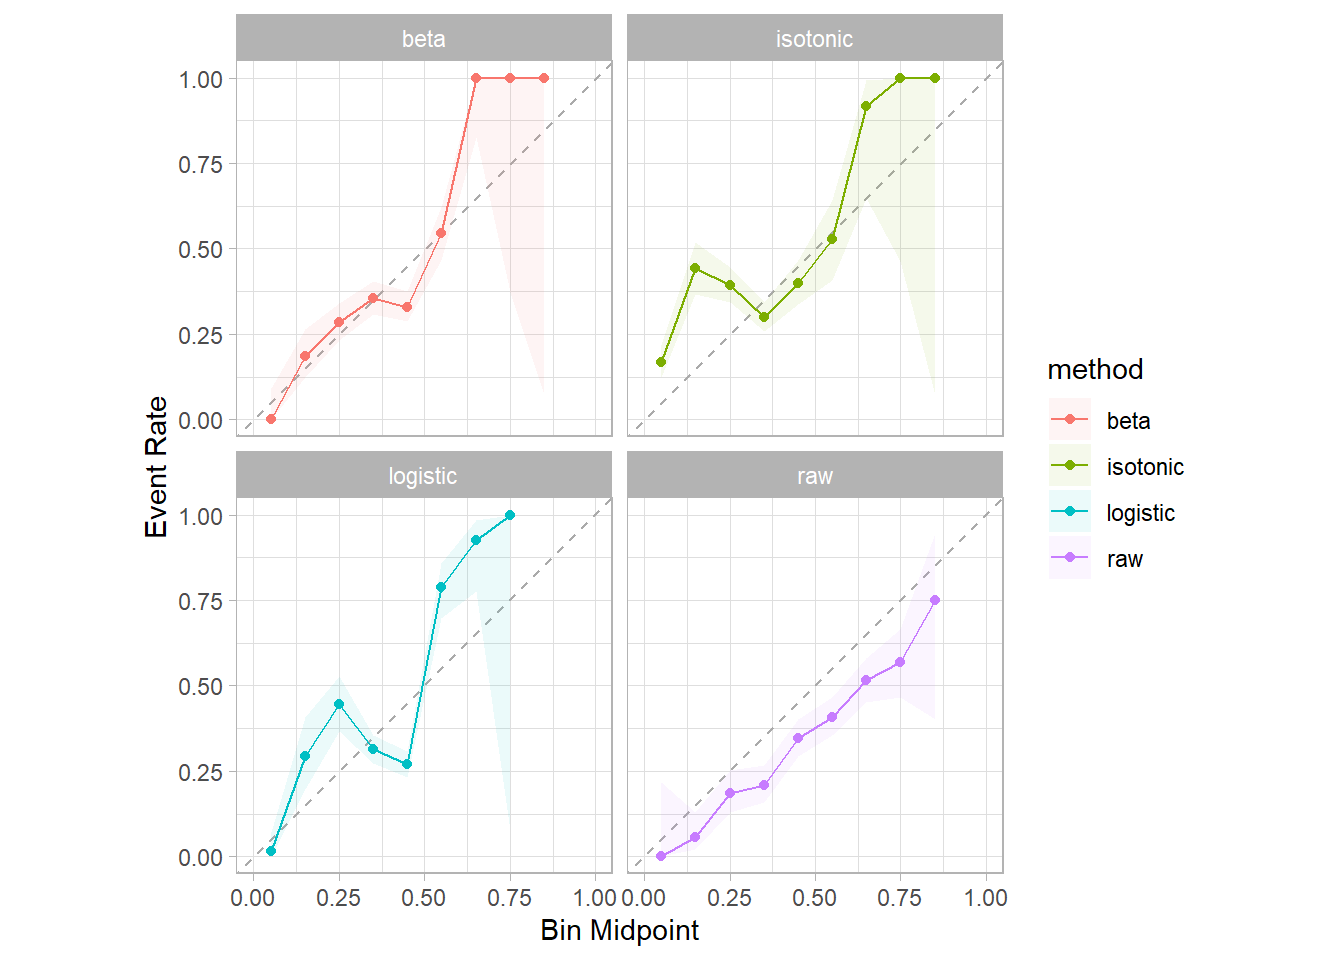

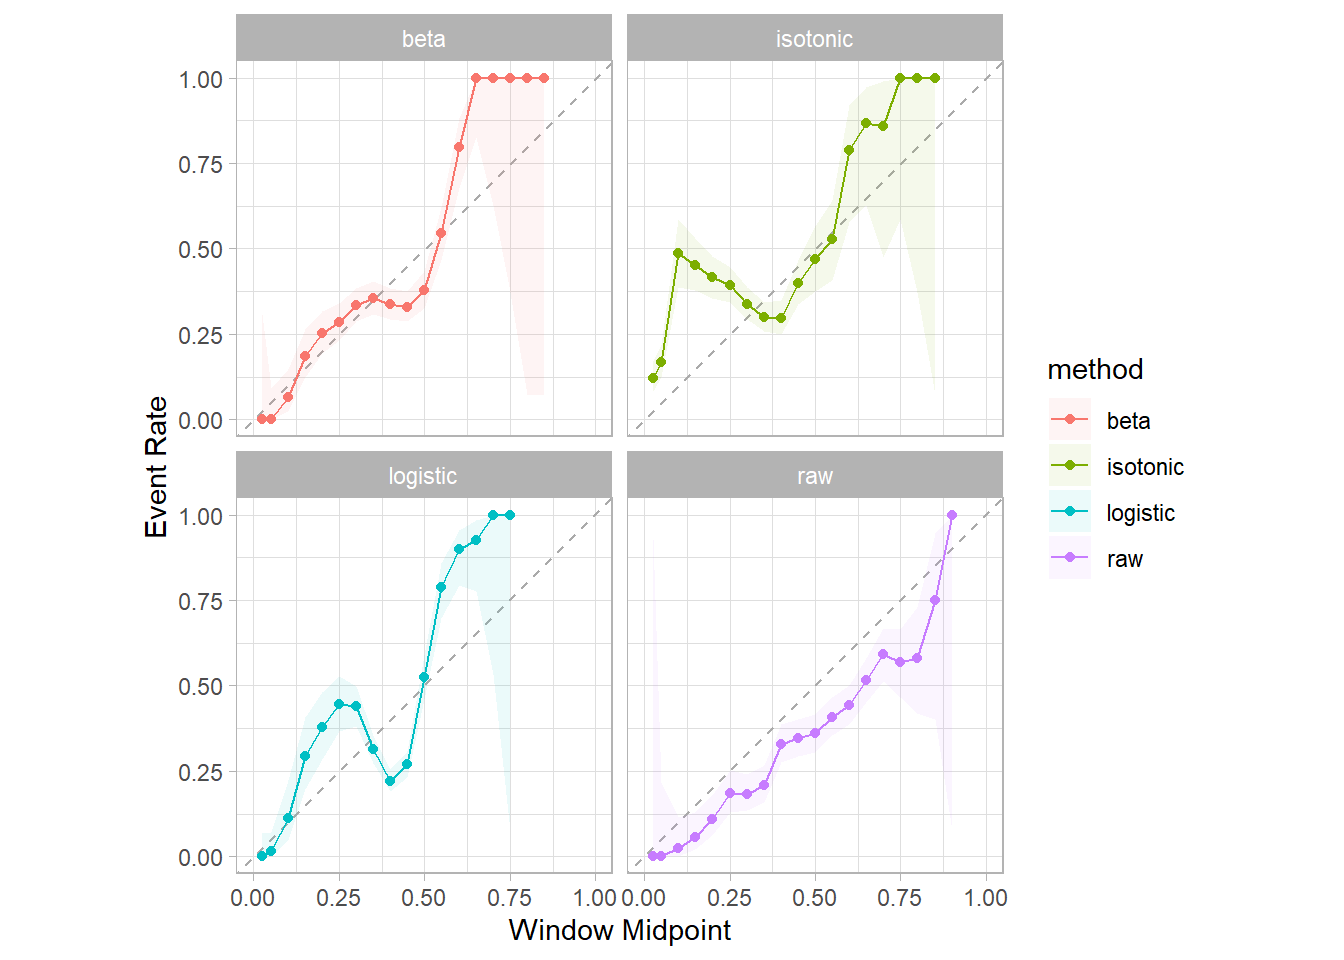

In [ ]:
d_plot |> 
  cal_plot_breaks(truth = outcome_rct_wk4, 
                  estimate = .pred_abstinent,
                  .by = method)


Raw probabilities appear the most well-calibrated: best aligned with diagonal line, spans the fullest range of bins/windows. Will use raw probabilities for AIM 2 analyses (selected above).

#### Brier score

Beta calibration

In [ ]:
brier_class_vec(truth = d_valid$outcome_rct_wk4,
                estimate = d_valid$beta)


[1] 0.2114336

Logistic calibration

In [ ]:
brier_class_vec(truth = d_valid$outcome_rct_wk4,
                estimate = d_valid$logistic)


[1] 0.2127456

Isotonic calibration

In [ ]:
brier_class_vec(truth = d_valid$outcome_rct_wk4,
                estimate = d_valid$isotonic)


[1] 0.228964

Raw calibration

In [ ]:
brier_class_vec(truth = d_valid$outcome_rct_wk4,
                estimate = d_valid$raw)


[1] 0.2159791

Beta calibration has the lowest Brier score index, followed closely by logistic calibration.